In [2]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb x11-utils

# install required python dependencies 
!pip install gym[box2d]==0.17.* pyvirtualdisplay==0.2.* PyOpenGL==3.1.* PyOpenGL-accelerate==3.1.*

Reading package lists... Done
Building dependency tree       
Reading state information... Done
xvfb is already the newest version (2:1.19.6-1ubuntu4.9).
Suggested packages:
  mesa-utils
The following NEW packages will be installed:
  libxxf86dga1 x11-utils
0 upgraded, 2 newly installed, 0 to remove and 37 not upgraded.
Need to get 209 kB of archives.
After this operation, 711 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libxxf86dga1 amd64 2:1.1.4-1 [13.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 x11-utils amd64 7.7+3build1 [196 kB]
Fetched 209 kB in 1s (293 kB/s)
Selecting previously unselected package libxxf86dga1:amd64.
(Reading database ... 157584 files and directories currently installed.)
Preparing to unpack .../libxxf86dga1_2%3a1.1.4-1_amd64.deb ...
Unpacking libxxf86dga1:amd64 (2:1.1.4-1) ...
Selecting previously unselected package x11-utils.
Preparing to unpack .../x11-utils_7.7+3build1_amd64.deb ...
Unpa

In [3]:
import gym
import random
import math
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import matplotlib.pyplot as plt
from moviepy.editor import ImageSequenceClip
from IPython import display as ipythondisplay

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)1892352/45929032 bytes (4.1%)5013504/45929032 bytes (10.9%)8298496/45929032 bytes (18.1%)11280384/45929032 bytes (24.6%)14188544/45929032 bytes (30.9%)17358848/45929032 bytes (37.8%)20635648/45929032 bytes (44.9%)23830528/45929032 bytes (51.9%)27009024/45929032 bytes (58.8%)30130176/45929032 bytes (65.6%)33177600/45929032 bytes (72.2%)36380672/45929032 bytes (79.2%)

# **Overview of Algorithm:**

For the algorithm I chose, the state space consists of four observations: the cart position, which can be any integer from -2.4 to 2.4, the cart velocity, which can be any real number, the pole angle, which can range from -41.8 degrees to +41.8 degrees, and the poles velocity at its tip, which can also be any real number. 

The action space consists of two possible actions: the agent can either push the cart pole left or right.

The environment reward is +1 for every step taken; this includes the final step.

The problem is considered solved when the average reward is >= 195.0 over 100 consecutive trials.


# **Q-Learning vs. DQN**

Q-Learning has three main steps: initializing the Q-table, choosing an action, and updating the Q-table using the Bellman Equation. Deep Q-Learning, on the other hand, is when a neural network maps input states to (action, Q-value) pairs. The Deep Q-Network algorithm also consists of three steps: initialzing the network weights, choosing an action, and updating the network weights using the Bellman Equation. 

For my chosen algorithm, using Q-Learning by itself would not be feasible as it requires a table with dimensions S x A, where S is the number of possible states and A is the number of possible actions in the environment; This table would be far too large to actually be usable. To solve this problem, a Deep Q-Network (DQN) is used, which approximates Q-values. For each time step, the current observations of the environment are passed as an input to the DQN, which outputs a Q-value that corresponds to the possible actions that can be taken.

average reward per episode : 21.53


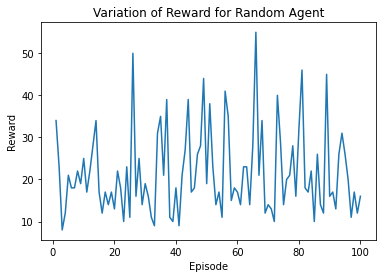

In [4]:
#Random agent:
from torch import randint
import matplotlib.pyplot as plt
import gym

rew_arr = []
episode_count = 100
episodes = list(range(1,101))
env = gym.make('CartPole-v0')
for i in range(episode_count):
    obs, done, rew = env.reset(), False, 0
    while done != True:
        A = randint(0, env.action_space.n, (1,))
        obs, reward, done, info = env.step(A.item())
        rew += reward
    rew_arr.append(rew)

def plot_durations():    
     plt.figure(2)
     plt.clf()
     plt.title('Variation of Reward for Random Agent')
     plt.xlabel('Episode')
     plt.ylabel('Reward')
     plt.plot(episodes, rew_arr)
     plt.savefig('random.png')

plot_durations()
print("average reward per episode :", sum(rew_arr) / len(rew_arr))

As seen in the graph above showing how the reward changes per episode with a random agent, there is no noticeable pattern in the reward. A more noticeable pattern can be observed as the number of episodes increases and the agent takes into account environmental information before choosing its next action.

In [5]:
import torch
from torch import nn
import copy
from collections import deque
import random

class DQN_Agent:

    def __init__(self, seed, layer_sizes, lr, sync_freq, exp_replay_size):
        torch.manual_seed(seed)
        self.q_net = self.build_nn(layer_sizes)
        self.target_net = copy.deepcopy(self.q_net)
        self.q_net.cuda()
        self.target_net.cuda()
        self.loss_fn = torch.nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.q_net.parameters(), lr=lr)

        self.network_sync_freq = sync_freq
        self.network_sync_counter = 0
        self.gamma = torch.tensor(0.95).float().cuda()
        self.experience_replay = deque(maxlen=exp_replay_size)
        return

    def build_nn(self, layer_sizes):
        assert len(layer_sizes) > 1
        layers = []
        for index in range(len(layer_sizes) - 1):
            linear = nn.Linear(layer_sizes[index], layer_sizes[index + 1])
            act = nn.Tanh() if index < len(layer_sizes) - 2 else nn.Identity()
            layers += (linear, act)
        return nn.Sequential(*layers)

    def load_pretrained_model(self, model_path="cartpole-dqn.pth"):
        self.q_net.load_state_dict(torch.load(model_path))

    def save_trained_model(self, model_path="cartpole-dqn.pth"):
        torch.save(self.q_net.state_dict(), model_path)

    def get_action(self, state, action_space_len, epsilon):
        # We do not require gradient at this point, because this function will be used either
        # during experience collection or during inference
        with torch.no_grad():
            Qp = self.q_net(torch.from_numpy(state).float().cuda())
        Q, A = torch.max(Qp, axis=0)
        A = A if torch.rand(1, ).item() > epsilon else torch.randint(0, action_space_len, (1,))
        return A

    def get_q_next(self, state):
        with torch.no_grad():
            qp = self.target_net(state)
        q, _ = torch.max(qp, axis=1)
        return q

    def collect_experience(self, experience):
        self.experience_replay.append(experience)
        return

    def sample_from_experience(self, sample_size):
        if len(self.experience_replay) < sample_size:
            sample_size = len(self.experience_replay)
        sample = random.sample(self.experience_replay, sample_size)
        s = torch.tensor([exp[0] for exp in sample]).float()
        a = torch.tensor([exp[1] for exp in sample]).float()
        rn = torch.tensor([exp[2] for exp in sample]).float()
        sn = torch.tensor([exp[3] for exp in sample]).float()
        return s, a, rn, sn

    def train(self, batch_size):
        s, a, rn, sn = self.sample_from_experience(sample_size=batch_size)
        if self.network_sync_counter == self.network_sync_freq:
            self.target_net.load_state_dict(self.q_net.state_dict())
            self.network_sync_counter = 0

        # predict expected return of current state using main network
        qp = self.q_net(s.cuda())
        pred_return, _ = torch.max(qp, axis=1)

        # get target return using target network
        q_next = self.get_q_next(sn.cuda())

        #Y = r(t) + gamma * q_next_state
        target_return = rn.cuda() + self.gamma * q_next

        loss = self.loss_fn(pred_return, target_return)
        self.optimizer.zero_grad()
        loss.backward(retain_graph=True)
        self.optimizer.step()

        self.network_sync_counter += 1
        return loss.item()


# **Steps in training process:**

1) Initialize the game state and receive the initial observations from the environment

2) Pass the observation as an input to the Q-network to get the corresponding Q-value for each action

3) Agent either selects random agent with probability epsilon or selects action that corresponds to maximum q value

4) In the game state, perform the selected action and then collect both the appropriate reward and the observation of the next state

5) Take the observations of the next state and pass them as inputs to the Q-network, store the max Q-value and calculate the ground truth using Y = r(t) + gamma * q_next_state

6) Calculate loss using the predicted return of the current state and the actual return, perform optimization step

7) Set observation equal to the next state observation

8) Repeat steps 2-7 for n episodes

100%|██████████| 1000/1000 [00:12<00:00, 78.05it/s]


Saving trained model


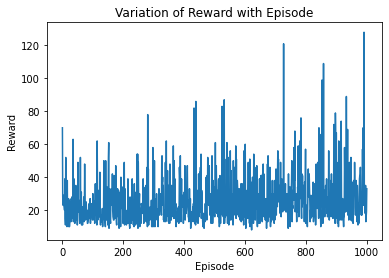

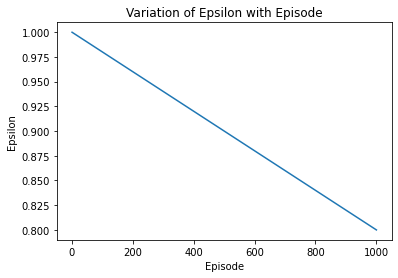

In [6]:
#1000 episode run
import gym
from tqdm import tqdm
import matplotlib.pyplot as plt

use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor
Tensor = FloatTensor

env = gym.make('CartPole-v0')
input_dim = env.observation_space.shape[0]
output_dim = env.action_space.n
exp_replay_size = 256
agent = DQN_Agent(seed=1423, layer_sizes=[input_dim, 64, output_dim], lr=1e-3, sync_freq=5,
                  exp_replay_size=exp_replay_size)

# Main training loop
losses_list, reward_list, episode_len_list, epsilon_list = [], [], [], []
episodes = 1000
episodelist = list(range(1,1001))
epsilon = 1

# initialize experience replay
index = 0
for i in range(exp_replay_size):
    obs = env.reset()
    done = False
    while not done:
        A = agent.get_action(obs, env.action_space.n, epsilon=1)
        obs_next, reward, done, _ = env.step(A.item())
        agent.collect_experience([obs, A.item(), reward, obs_next])
        obs = obs_next
        index += 1
        if index > exp_replay_size:
            break

index = 128
for i in tqdm(range(episodes)):
    obs, done, losses, ep_len, rew = env.reset(), False, 0, 0, 0
    while not done:
        ep_len += 1
        A = agent.get_action(obs, env.action_space.n, epsilon)
        obs_next, reward, done, _ = env.step(A.item())
        agent.collect_experience([obs, A.item(), reward, obs_next])

        obs = obs_next
        rew += reward
        index += 1

        if index > 128:
            index = 0
            for j in range(4):
                loss = agent.train(batch_size=16)
                losses += loss
    if epsilon > 0.05:
        epsilon -= (1 / 5000)

    losses_list.append(losses / ep_len), reward_list.append(rew)
    episode_len_list.append(ep_len), epsilon_list.append(epsilon)

def plot_reward():
    plt.figure()
    plt.clf()
    plt.title('Variation of Reward with Episode')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.plot(episodelist, reward_list)
    plt.savefig('reward1000.png')

def plot_epsilon():
    plt.figure()
    plt.clf()
    plt.title('Variation of Epsilon with Episode')
    plt.xlabel('Episode')
    plt.ylabel('Epsilon')
    plt.plot(episodelist, epsilon_list)
    plt.savefig('epsilon1000.png')

print("Saving trained model")
agent.save_trained_model("cartpole-dqn1000.pth")
plot_reward()
plot_epsilon()

100%|██████████| 7000/7000 [03:13<00:00, 36.26it/s]


Saving trained model


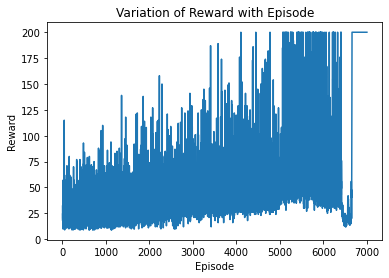

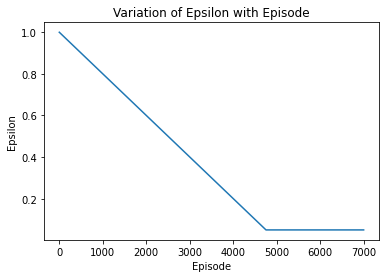

In [8]:
#7000 episode run
import gym
from tqdm import tqdm
import matplotlib.pyplot as plt

env = gym.make('CartPole-v0')
input_dim = env.observation_space.shape[0]
output_dim = env.action_space.n
exp_replay_size = 256
agent = DQN_Agent(seed=1423, layer_sizes=[input_dim, 64, output_dim], lr=1e-3, sync_freq=5,
                  exp_replay_size=exp_replay_size)

# Main training loop
losses_list, reward_list, episode_len_list, epsilon_list = [], [], [], []
episodes = 7000
episodelist = list(range(1,7001))
epsilon = 1

# initialize experience replay
index = 0
for i in range(exp_replay_size):
    obs = env.reset()
    done = False
    while not done:
        A = agent.get_action(obs, env.action_space.n, epsilon=1)
        obs_next, reward, done, _ = env.step(A.item())
        agent.collect_experience([obs, A.item(), reward, obs_next])
        obs = obs_next
        index += 1
        if index > exp_replay_size:
            break

index = 128
for i in tqdm(range(episodes)):
    obs, done, losses, ep_len, rew = env.reset(), False, 0, 0, 0
    while not done:
        ep_len += 1
        A = agent.get_action(obs, env.action_space.n, epsilon)
        obs_next, reward, done, _ = env.step(A.item())
        agent.collect_experience([obs, A.item(), reward, obs_next])

        obs = obs_next
        rew += reward
        index += 1

        if index > 128:
            index = 0
            for j in range(4):
                loss = agent.train(batch_size=16)
                losses += loss
    if epsilon > 0.05:
        epsilon -= (1 / 5000)

    losses_list.append(losses / ep_len), reward_list.append(rew)
    episode_len_list.append(ep_len), epsilon_list.append(epsilon)

def plot_reward():
    plt.figure()
    plt.clf()
    plt.title('Variation of Reward with Episode')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.plot(episodelist, reward_list)
    plt.savefig('reward6500.png')

def plot_epsilon():
    plt.figure()
    plt.clf()
    plt.title('Variation of Epsilon with Episode')
    plt.xlabel('Episode')
    plt.ylabel('Epsilon')
    plt.plot(episodelist, epsilon_list)
    plt.savefig('epsilon6500.png')

print("Saving trained model")
agent.save_trained_model("cartpole-dqn6500.pth")
plot_reward()
plot_epsilon()

As seen in the "Variation of Reward with Episode" and "Variation of Epsilon with Episode" graphs for 1000 and 7000 tests, the agent earns the maximum reward in each episode after about 6600 episodes. The reward plot for the 1000 episode run shows a slight upwards pattern, but does not reach the maximum reward. As for the variation in epsilon, which is the probability that a random action is selected (exploration), it starts at 1, which means 100% exploration. Over time, epsilon slowly decreases to a lower limit of 0.05. This lower limit of 0.05 can only be observed in the 7000 episode run, where we can observe that epsilon reaches 0.05 after about 4700 episodes.